# Build your first Neural Network from scratch
## This Notebook is intended to guide you trough the construction of a simple fully connected Neural Network without using specific deeplearning frameworks

In [1]:
import numpy as np
from typing import List,Sequence

## Fully Connected Neural Network (FCNN) Architecture

<div>
    <img src ="Images/NN_architecture.png" width = "600">
</div>

## Weights and Bias 
each layer of the Neural Network is composed by a Matrix of weights and a bias vector, this hepls to simplify the implemnetation\
the shape of the weigth matrix is [Current_Layer_Nodes, Prev_Layer_Nodes]\
and the bias is [Current_Layer_Nodes, 1]

the first step in the construction of our Neural Network is initialize the weigths and biases for each layer


In [ ]:
# complete the following function to initialize the weigths and bias for one layer, remember check the proper shape of the elements
# randomly inilize the elements using a Gaussian distributions with mean 0 and standard deviation 1
def init_layer(prev_layer:int, curr_layer:int) ->list[np.array]:
    weigths =  #your code goes here
    bias = #your code goes here
    return weigths,bias

## Layer feed forward
<div>
    <img src ="Images/NN_layer.png" width = "500">
</div>

the output of each layer in a FCNN can be calculated in two steps:\
first calculate the preactivation (z) using the formula, $z = w^T x +b$
and pass hte result trough some activation function $g(z)$

In [ ]:
# complete the following function to calculate the preactivation (z) calultaion for one layer
def layer_preactivation(weights:np.array,bias:np.array,x:np.array)->np.array:
    z = #your code goes here
    return z
    

## activation functions examples

<div>
    <img src ="Images/activation_functions.png" width = "700">
</div>

The activation function is a mathematical function that is used within neural networks and decides whether a neuron is activated or not.\
It processes the weighted sum of the neuron’s inputs and calculates a new value to determine how strongly the signal is passed on to the next layer\
in the network, for this notebook we will use ReLu and Sigmoid activation functions

In [ ]:
#Implement ReLU activation function
def relu(x: float)->float:
    g = np.maximum(0,x)
    return g

In [ ]:
#implement ReLu Prime function (relu_derivative)
def relu_prime(x: float)->float:
    gp = 1 if (x>0) else 0
    return gp

In [ ]:
#Implement Sigmoid activation function
def sigmoid(x:float)->float:
    g = 1/(1+np.e**-x)
    return g

In [ ]:
#implement Sigmoid Prime function (sigmoid_derivative)
def sigmoid_prime(x:float)->float:
    gp=sigmoid(x)*(1-sigmoid(x))
    return gp

# **Train a Neural Network with Gradient Descent** 

## Gradient Descent Algorithm
1. **Feedforward:** compute preactivation and activation for each layer 
2. **Calculate Output error:** calculate error in the final layer using a cost function
3. **Propagate Error:** use back propagation to estimate the contribution of each weight to the final error
4. **Update Weights:** update weigths and bias using the following equations:
    - $w = w - \alpha *\delta^ w$
    - $b = b - \alpha *\delta^ b$
      
repeat the algorithm for a fixed number of epochs or until some condition is met

## back propagation equations:
$\large \delta^L = \nabla_a C \odot \sigma'(z^L).$ 

$\large  \delta^l = ((w^{l+1})^T \delta^{l+1}) \odot \sigma'(z^l) $

$\large  \frac{\partial C}{\partial w^l_{jk}} = a^{l-1}_k \delta^l_j. $

$\large  \frac{\partial C}{\partial b^l_{j}} = \delta^l_j. $

## Now Lets use all the blocks to create the simple_nn class

In [16]:
# simple FCNN to use create an object and pass the layers configuration  and the activations list for example
# my_nn = simple_nn([5,4,2],['relu','sigmoid']) this will create a NN with 3 layers, each number is the number of neurons in the layer
# the hiden layeer will use relu activation and the output layer will use sigmoid

map_act   = {'relu': relu, 'sigmoid':sigmoid}
map_prime = {'relu': relu_prime, 'sigmoid':sigmoid_prime}

class simple_nn():
    def __init__(self,layers, activations):
        self.num_layers=len(layers) # save NN structure
        self.activations = activations # list of activation function per layer, except input layer
        self.weights = []
        self.bias = []
        for prev_layer, curr_layer in zip(layers,layers[1:]):
            w,b= init_layer(prev_layer, curr_layer)
            self.weights.append(w)
            self.bias.append(b)

    def forward_propagation(self,input_vector):
        #forward propagation, hidden layers use ReLU activation function and ouput layer use sigmoid activation function
        #loop trough intermediate layers
        x=input_vector
        for i in range(self.num_layers-1):
            #calculate preactivation
            z=layer_preactivation(self.weights[i],self.bias[i],x)
            #calcute activation 
            g= map_act[self.activations[i]]
            a=np.vectorize(g)(z)
            x=a # update next layer input 

        return x
    
    '''
    back propagation for cuadratic cost function  " C=(1/2)*(y-out)**2 "
    return "delta_b" and "delta_w" representing the gradient propagation trough each layer
    this variables have the same dimensions than self.weights and self.bias
    '''
    def backward_propagation(self,x,y):
        #feed forward and save outputs
        layers_z=[x]
        layers_a=[x] 
     
        for i in range(self.num_layers-1):
            #calculate preactivation
            z=layer_preactivation(self.weights[i],self.bias[i],x)
            #calcute activation 
            g= map_act[self.activations[i]]
            a=np.vectorize(g)(z)
            #strore output and activation for each layer
            layers_z.append(z)
            layers_a.append(a)
            x=a # update next layer input 
  
        #initialize variables to store error by layer
        delta_b = [np.zeros(b.shape) for b in self.bias]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        
        #calculate last layer error and gradient
        cost_gradient = (layers_a[-1]-y) # cost function gradient 
        gp= map_prime[self.activations[i-1]]
        delta = cost_gradient*np.vectorize(gp)(layers_z[-1])
        delta_w[-1] = np.dot(delta,layers_a[-2].transpose())
        delta_b[-1] = delta
        #propagate error trough hiden layers
        for l in range(2, self.num_layers):
            z = layers_z[-l]
            gp= map_prime[self.activations[-l]]
            rp = np.vectorize(gp)(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) *rp
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta, layers_a[-l-1].transpose())

        cost= 0.5*(layers_a[-1]-y)**2 #quadratic cost function
        
        return delta_b,delta_w,cost

    
    def update_minibatch(self,x,y,alpha):
        #update weigths and bias  for a minibatch (array of x and y pairs)
        #alpha is the learning rate

        #initialize variables to store error
        delta_b = [np.zeros(b.shape) for b in self.bias]
        delta_w = [np.zeros(w.shape) for w in self.weights]
        cost=0
        #iterate trough pairs
        m = len(x) #number of samples in batch
        for i in range(m):
            #calculate delta for each x,y pair 
            xi=  x[[i]].T #slice array and transpose (size = (inputs,1))
            yi = y[i]  
            dbi,dwi,cost_i= self.backward_propagation(xi,yi)
            #sum error for each pair in minibatch
            delta_b = [db+dnb for db, dnb in zip(delta_b, dbi)]
            delta_w = [dw+dnw for dw, dnw in zip(delta_w, dwi)]

            cost+=cost_i

            
        #update weights using learning rate (alpha) divided by the number of elements in minibatch
        
        self.weights = [w - (alpha/m)*nw for w,nw in zip(self.weights,delta_w)]
        self.bias    = [b - (alpha/m)*nb for b,nb in zip(self.bias,delta_b)]

        return cost/m          
            

## We will test and train our new neural network using some artificial data generated using [scikit make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons)\

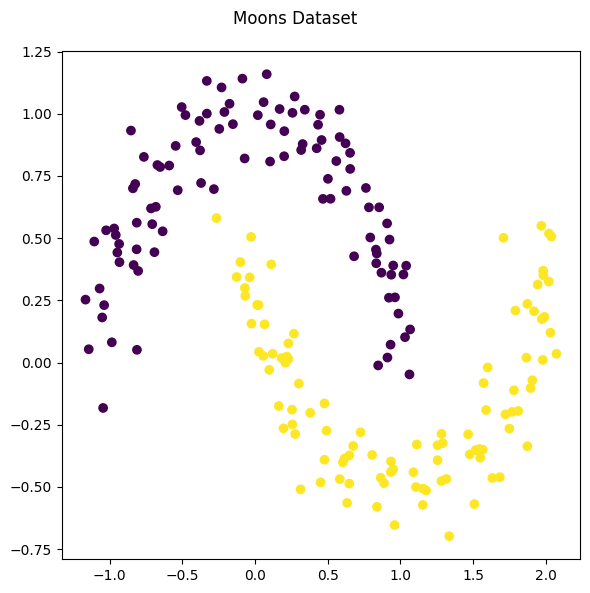

In [9]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

fig,ax  = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

X, Y = make_moons(noise=0.1, random_state=0,n_samples = 200)
ax.scatter(X[:, 0], X[:, 1], c=Y)
plt.suptitle("Moons Dataset")

plt.tight_layout()
plt.show()

In [10]:
# The code for back propagation and update minibatch is provided to you in the NN class,
# lets use this to train the Neural Network, t
def train_nn(NN:simple_nn , X_train:np.array, Y_train:np.array,batch_size, alpha : float, epochs:int):
    n_batchs = len(X_train)//batch_size # calculate number of batchs
    logs=[]
    for it in range(epochs):
        cost = 0 # restart cost for every epoch
        for i in range(n_batchs):
            #create mini batch
            xb = X_train[i*batch_size:(i+1)*batch_size]
            yb = Y_train[i*batch_size:(i+1)*batch_size] 
            # update weigths for the minibatch
            batch_cost = NN.update_minibatch(x=xb,y=yb,alpha=alpha) 
            cost += batch_cost.item()
        #calculate training metrics
        cost = cost/n_batchs
        y_pred =1*(NN.forward_propagation(X_train.T)>0.5)
        train_accuracy = np.sum(y_pred==Y_train) /len(Y_train)
        logs.append([cost,train_accuracy]) #save all costs

        #print every 20 epochs
        if(it%20 == 0): 
            print ("epoch {} finished, train_cost = {:0.3f}, train_accuracy = {:0.3f} ".format(it,cost,train_accuracy))

    return logs

### Lets create a NN with the following configuration:
   - 2 neurons in the input layer
   - 8 neurons in the hidden layer, activation 'relu'
   - 1 neuron in the output layer, activation 'sigmoid'

In [47]:
my_nn = simple_nn([2,8,1],['relu','sigmoid'])

In [48]:
#split the dataset in test and train 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
logs = train_nn(my_nn,X_train,y_train,batch_size=10,alpha=0.01,epochs=500)

epoch 0 finished, train_cost = 0.111, train_accuracy = 0.543 
epoch 20 finished, train_cost = 0.083, train_accuracy = 0.821 
epoch 40 finished, train_cost = 0.073, train_accuracy = 0.850 
epoch 60 finished, train_cost = 0.064, train_accuracy = 0.857 
epoch 80 finished, train_cost = 0.059, train_accuracy = 0.871 
epoch 100 finished, train_cost = 0.055, train_accuracy = 0.871 
epoch 120 finished, train_cost = 0.051, train_accuracy = 0.871 
epoch 140 finished, train_cost = 0.047, train_accuracy = 0.864 
epoch 160 finished, train_cost = 0.044, train_accuracy = 0.871 
epoch 180 finished, train_cost = 0.043, train_accuracy = 0.879 
epoch 200 finished, train_cost = 0.042, train_accuracy = 0.879 
epoch 220 finished, train_cost = 0.041, train_accuracy = 0.886 
epoch 240 finished, train_cost = 0.041, train_accuracy = 0.886 
epoch 260 finished, train_cost = 0.040, train_accuracy = 0.893 
epoch 280 finished, train_cost = 0.040, train_accuracy = 0.893 
epoch 300 finished, train_cost = 0.040, train_

# PLot Neural Network Training Perormance Metrics

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

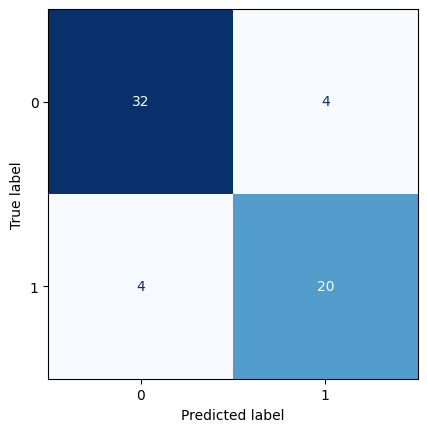

In [58]:
y_pred =1*(my_nn.forward_propagation(X_test.T)>0.5)
CM =confusion_matrix(y_test.T,y_pred.T)
disp = ConfusionMatrixDisplay(CM)
disp.plot(cmap=plt.cm.Blues,colorbar=False)

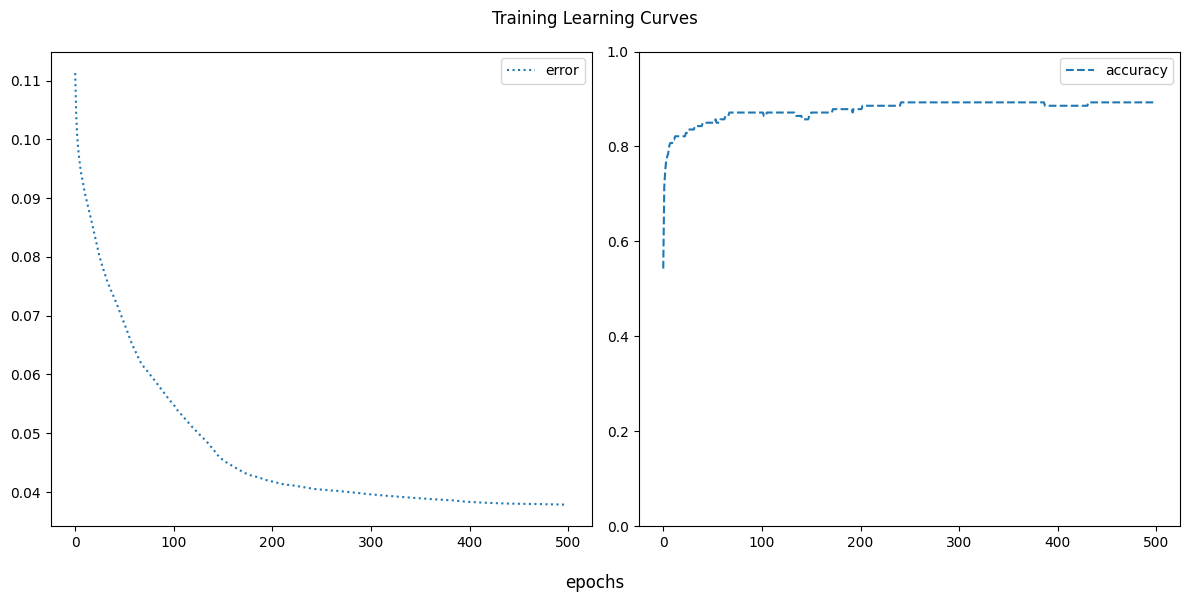

In [52]:
## plot Neural Network Learning curves
fig,(ax1,ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
data = np.asarray(logs)

ax1.plot(data[:,0],linestyle = 'dotted',label = 'error')
ax1.legend()

ax2.plot(data[:,1],linestyle = 'dashed', label ='accuracy')
ax2.set_ylim(0,1)
ax2.legend()

fig.suptitle("Training Learning Curves")
fig.supxlabel("epochs")
plt.tight_layout()
plt.show()

# Solutions to excersises

In [2]:
def init_layer(prev_layer:int, curr_layer:int) ->list[np.array]:
    weigths =  np.random.normal(loc= 0 ,scale= 1.0/curr_layer, size=(curr_layer,prev_layer))
    bias = np.random.normal(loc= 0 ,scale= 1.0/curr_layer,size=(curr_layer,1))
    return weigths,bias

In [3]:
# complete the following function to calculate the preactivation (z) calultaion for one layer
def layer_preactivation(weights:np.array,bias:np.array,x:np.array)->np.array:
    z = np.dot(weights,x)+bias
    return z

In [4]:
#Implement ReLU activation function
def relu(x: float)->float:
    g = np.maximum(0,x)
    return g

In [5]:
#implement ReLu Prime function (relu_derivative)
def relu_prime(x: float)->float:
    gp = 1 if (x>0) else 0
    return gp

In [6]:
#Implement Sigmoid activation function
def sigmoid(x:float)->float:
    g = 1/(1+np.e**-x)
    return g

In [7]:
#implement Sigmoid Prime function (sigmoid_derivative)
def sigmoid_prime(x:float)->float:
    gp=sigmoid(x)*(1-sigmoid(x))
    return gp

## references:
- https://towardsdatascience.com/activation-functions-in-neural-networks-how-to-choose-the-right-one-cb20414c04e5/
- http://neuralnetworksanddeeplearning.com/chap1.html#implementing_our_network_to_classify_digits